**import packages**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

**Load The Dataset**

In [2]:
customers = pd.read_csv(r"C:\Users\HP\Downloads\Customers.csv")

products = pd.read_csv(r"C:\Users\HP\Downloads\Products.csv")

transactions = pd.read_csv(r"C:\Users\HP\Downloads\Transactions.csv")
print(customers.head())
print(products.head())
print(transactions.head())


  CustomerID        CustomerName         Region  SignupDate
0      C0001    Lawrence Carroll  South America  2022-07-10
1      C0002      Elizabeth Lutz           Asia  2022-02-13
2      C0003      Michael Rivera  South America  2024-03-07
3      C0004  Kathleen Rodriguez  South America  2022-10-09
4      C0005         Laura Weber           Asia  2022-08-15
  ProductID              ProductName     Category   Price
0      P001     ActiveWear Biography        Books  169.30
1      P002    ActiveWear Smartwatch  Electronics  346.30
2      P003  ComfortLiving Biography        Books   44.12
3      P004            BookWorld Rug   Home Decor   95.69
4      P005          TechPro T-Shirt     Clothing  429.31
  TransactionID CustomerID ProductID      TransactionDate  Quantity  \
0        T00001      C0199      P067  2024-08-25 12:38:23         1   
1        T00112      C0146      P067  2024-05-27 22:23:54         1   
2        T00166      C0127      P067  2024-04-25 07:38:55         1   
3       

**Merge customer and transaction data**

In [3]:
merged_data = pd.merge(transactions, customers, on="CustomerID")
merged_data = pd.merge(merged_data, products, on="ProductID")

**Feature Engineering: Let's use features like TotalValue, Quantity, and SignupDate**


In [4]:
merged_data['SignupDate'] = pd.to_datetime(merged_data['SignupDate'])
merged_data['SignupDays'] = (pd.to_datetime('today') - merged_data['SignupDate']).dt.days


**Aggregating customer-level data: TotalValue, Quantity, and TransactionCount**


In [5]:
customer_data = merged_data.groupby('CustomerID').agg(
    TotalValue=('TotalValue', 'sum'),
    Quantity=('Quantity', 'sum'),
    TransactionCount=('TransactionID', 'nunique'),
    SignupDays=('SignupDays', 'mean')
).reset_index()

**Correlation plot**

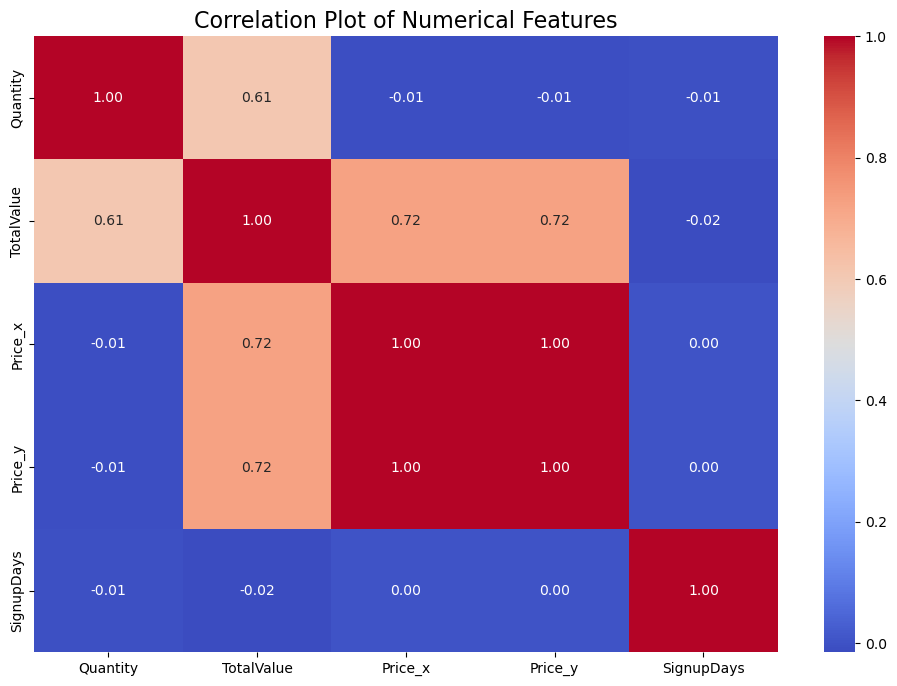

In [6]:
numerical_data = merged_data.select_dtypes(include=['float64', 'int64'])
correlation_matrix = numerical_data.corr()
plt.figure(figsize=(12, 8))

sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)

plt.title('Correlation Plot of Numerical Features', fontsize=16)

plt.show()


**Feature Scaling**

In [7]:
from sklearn.preprocessing import StandardScaler
features = ['TotalValue', 'Quantity', 'TransactionCount', 'SignupDays']
X = customer_data[features]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

**Train KNN Model with Cosine Similarity**

In [8]:
from sklearn.neighbors import NearestNeighbors

knn = NearestNeighbors(n_neighbors=4, metric="cosine")
knn.fit(X_scaled)

NearestNeighbors(metric='cosine', n_neighbors=4)

**Generate top 3 similar customers for the first 20 customers**


In [11]:
lookalike_results = {}

for customer_id in customer_data['CustomerID'].iloc[:20]:  
    customer_index = customer_data[customer_data['CustomerID'] == customer_id].index[0]
    distances, indices = knn.kneighbors([X_scaled[customer_index]], n_neighbors=4)
    
    similar_customers = customer_data.iloc[indices[0][1:4]]["CustomerID"].values
    similarity_scores = 1 - distances[0][1:4]
    
    lookalike_results[customer_id] = {
        'SimilarCustomer1': similar_customers[0], 'Score1': similarity_scores[0],
        'SimilarCustomer2': similar_customers[1], 'Score2': similarity_scores[1],
        'SimilarCustomer3': similar_customers[2], 'Score3': similarity_scores[2]
    }

lookalike_df = pd.DataFrame.from_dict(lookalike_results, orient='index')

lookalike_df.reset_index(inplace=True)
lookalike_df.columns = ['CustomerID', 'SimilarCustomer1', 'Score1', 'SimilarCustomer2', 'Score2', 'SimilarCustomer3', 'Score3']

lookalike_df


,CustomerID,SimilarCustomer1,Score1,SimilarCustomer2,Score2,SimilarCustomer3,Score3
0,C0001,C0152,0.979093,C0107,0.967095,C0038,0.963360
1,C0002,C0029,0.997089,C0166,0.986622,C0027,0.968148
2,C0003,C0111,0.876639,C0190,0.853365,C0030,0.852538
3,C0004,C0165,0.995039,C0175,0.993545,C0109,0.982742
4,C0005,C0198,0.997377,C0159,0.996523,C0131,0.996311
5,C0006,C0066,0.886595,C0117,0.866760,C0026,0.860962
6,C0007,C0125,0.998947,C0193,0.992873,C0074,0.988576
7,C0008,C0090,0.984863,C0017,0.944316,C0084,0.942201
8,C0009,C0128,0.983068,C0097,0.974480,C0186,0.971505
9,C0010,C0027,0.932595,C0199,0.922740,C0073,0.919188


**Save to CSV**

In [12]:

lookalike_df.to_csv('Satish_dwivedi_Lookalike.csv', index=False)
